In [1]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model

In [2]:
wireplane = "U"
np.random.seed(77)

In [3]:
loaded_data = np.load('/home/vlian/Workspace/ar39_samples/processed/ar39_dataset.npz', allow_pickle=True)
dataset = loaded_data['data']
scalers = loaded_data['scalers']

EACH adc group is formated like this:
> [ [x_train, y_train], [x_valid, y_valid], [x_test, y_test] ]

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv1DTranspose

#from keras import backend as K

In [6]:
time_periods = 200
autoencoder = Sequential()
# encoder
autoencoder.add(Conv1D(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu", input_shape=(time_periods,1)))
autoencoder.add(Conv1D(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1D(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))

# decoder
autoencoder.add(Conv1DTranspose(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu"))

autoencoder.add(Conv1DTranspose(filters=1, kernel_size=3, padding="same"))

adam_optimizer = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(loss='mse', optimizer=adam_optimizer)
autoencoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            2592      
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 64)             18496     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 25, 64)           36928     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          10272     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 200, 16)          1

In [7]:
for i,layer in enumerate(autoencoder.layers):                                      
    print(i,layer.name)

0 conv1d
1 conv1d_1
2 conv1d_2
3 conv1d_transpose
4 conv1d_transpose_1
5 conv1d_transpose_2
6 conv1d_transpose_3


In [8]:
train_idx = 0
val_idx = 1
test_idx = 2

x_idx = 0
y_idx = 1

In [9]:
# sudo
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

full_history = []
batch_size_ = 4096
for adc_grp in range(10, -1, -1):
    print('training set: ', adc_grp)
    x_train_scaled = (dataset[adc_grp][train_idx][x_idx]-scalers[0])/scalers[1]
    y_train_scaled = (dataset[adc_grp][train_idx][y_idx]-scalers[0])/scalers[1]
    
    x_valid_scaled = (dataset[adc_grp][val_idx][x_idx]-scalers[0])/scalers[1]
    y_valid_scaled = (dataset[adc_grp][val_idx][y_idx]-scalers[0])/scalers[1]

    print('begin training...')
    history = autoencoder.fit(x_train_scaled, y_train_scaled, 
                        batch_size=batch_size_, callbacks= [earlystop],
                        validation_data=(x_valid_scaled, y_valid_scaled), 
                        epochs=1000, verbose=1)
    full_history.append(history)
    

training set:  10
begin training...
Epoch 1/1000
24/24 [==============================] - 13s 96ms/step - loss: 0.1827 - val_loss: 0.1434
Epoch 2/1000
24/24 [==============================] - 1s 33ms/step - loss: 0.1196 - val_loss: 0.0937
Epoch 3/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.0755 - val_loss: 0.0586
Epoch 4/1000
24/24 [==============================] - 1s 33ms/step - loss: 0.0499 - val_loss: 0.0429
Epoch 5/1000
24/24 [==============================] - 1s 34ms/step - loss: 0.0390 - val_loss: 0.0358
Epoch 6/1000
24/24 [==============================] - 1s 39ms/step - loss: 0.0337 - val_loss: 0.0319
Epoch 7/1000
24/24 [==============================] - 1s 33ms/step - loss: 0.0305 - val_loss: 0.0293
Epoch 8/1000
24/24 [==============================] - 1s 33ms/step - loss: 0.0282 - val_loss: 0.0272
Epoch 9/1000
24/24 [==============================] - 1s 33ms/step - loss: 0.0262 - val_loss: 0.0256
Epoch 10/1000
24/24 [==============================] -

In [10]:
len(full_history)

11

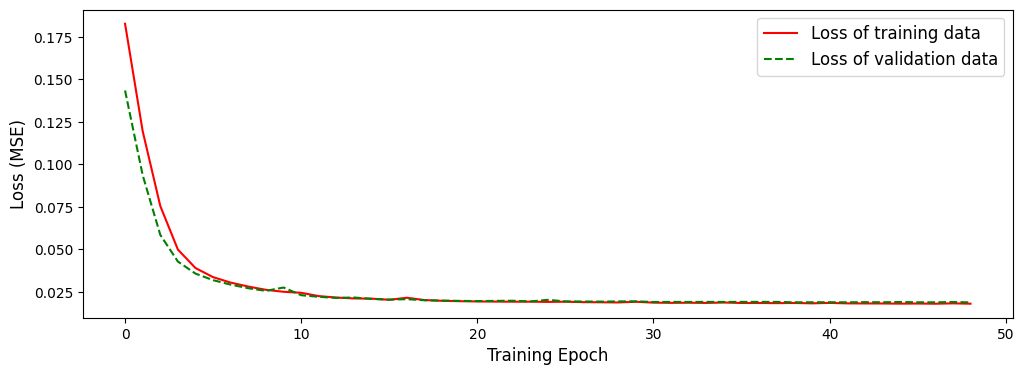

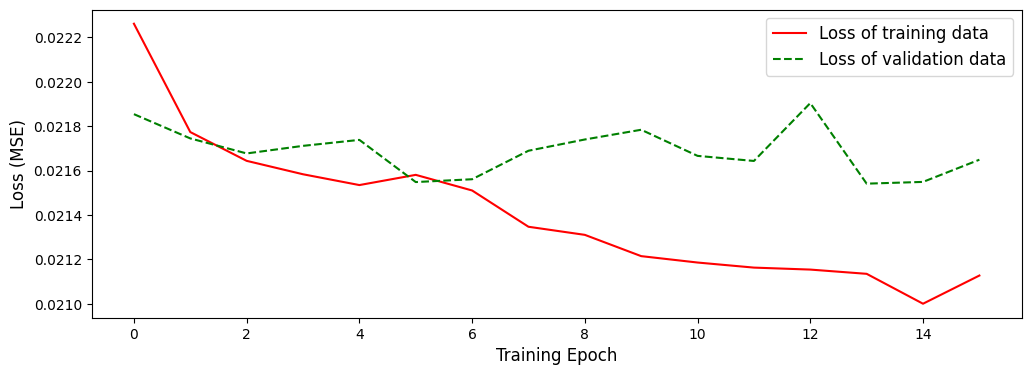

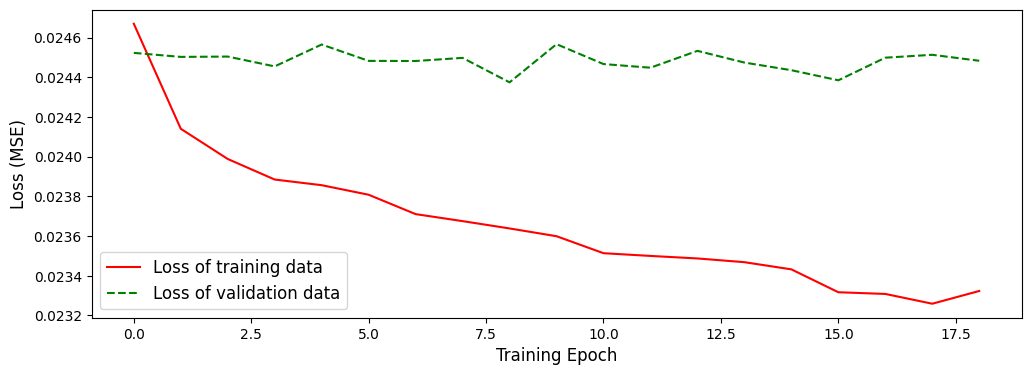

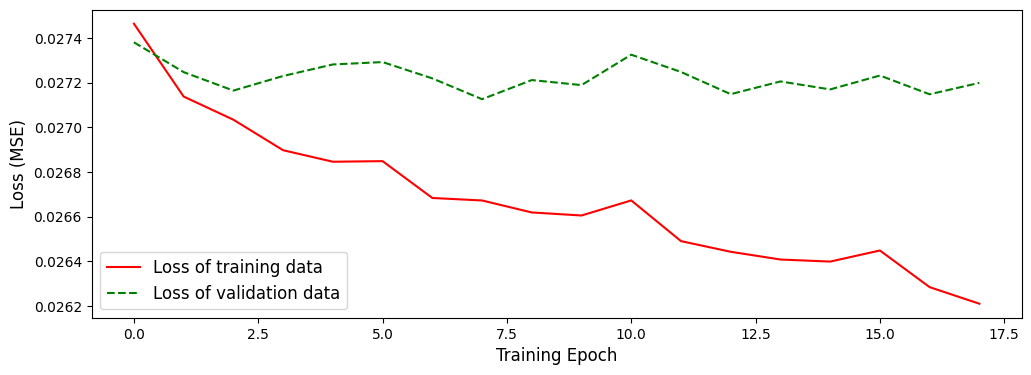

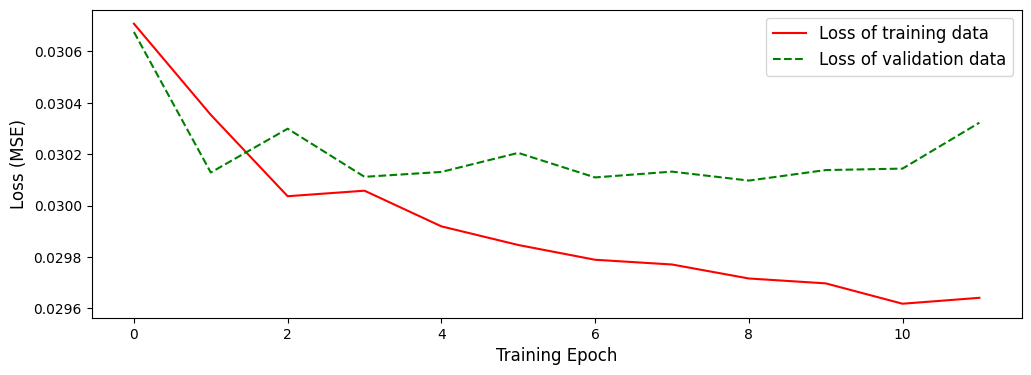

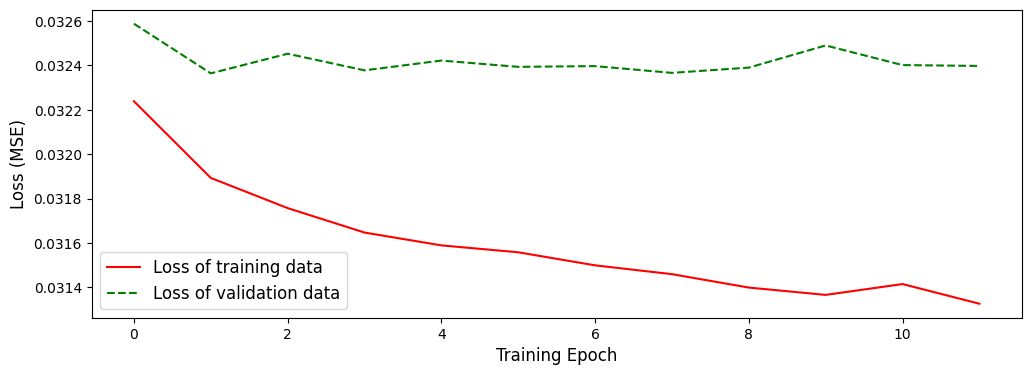

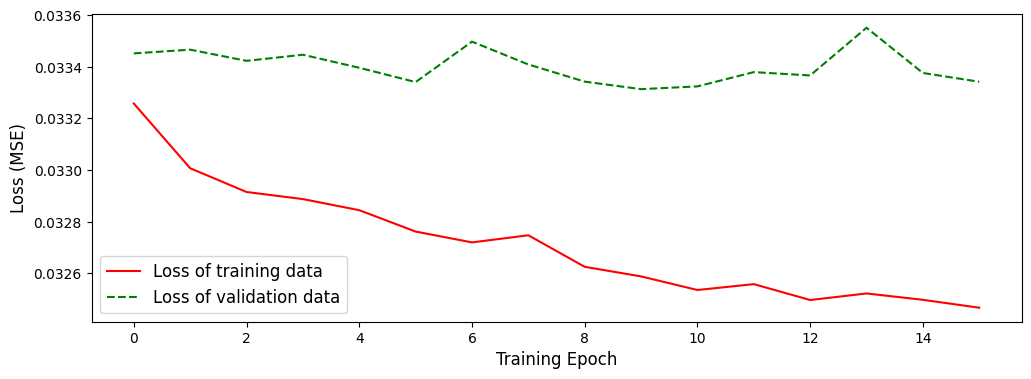

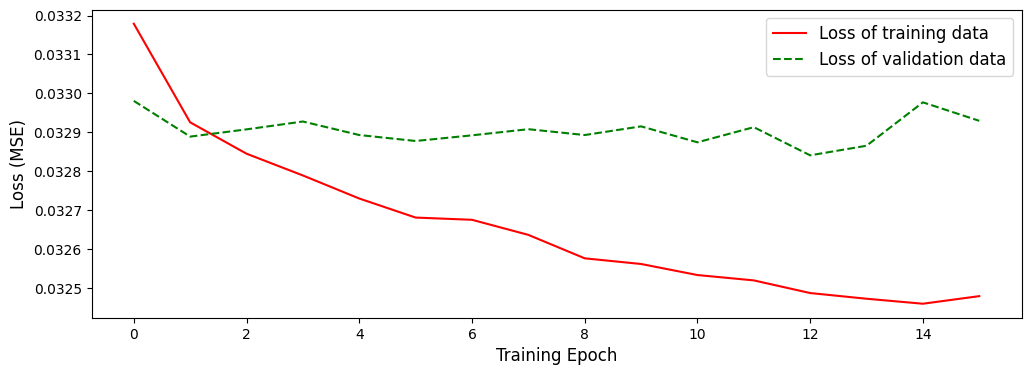

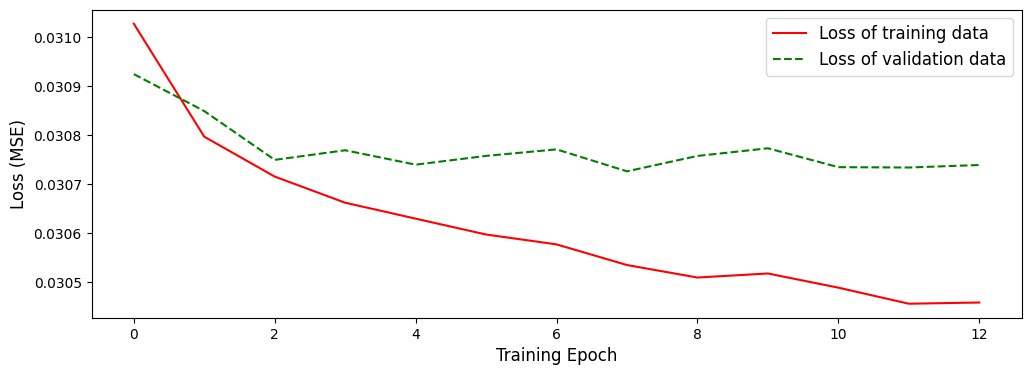

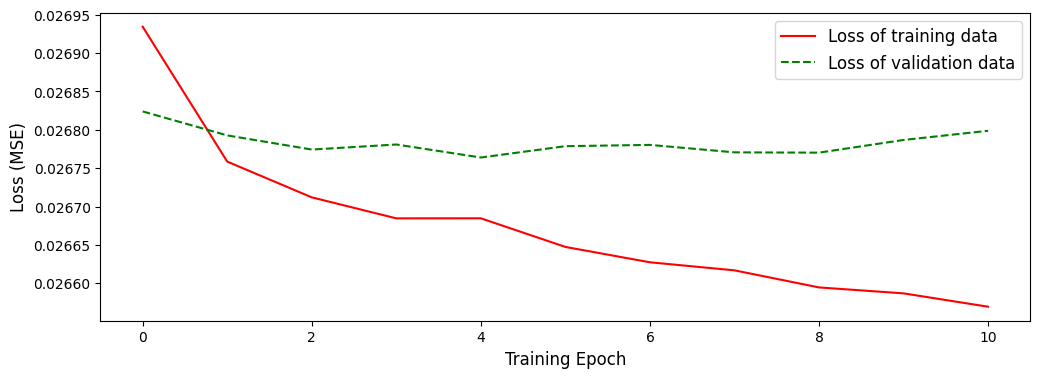

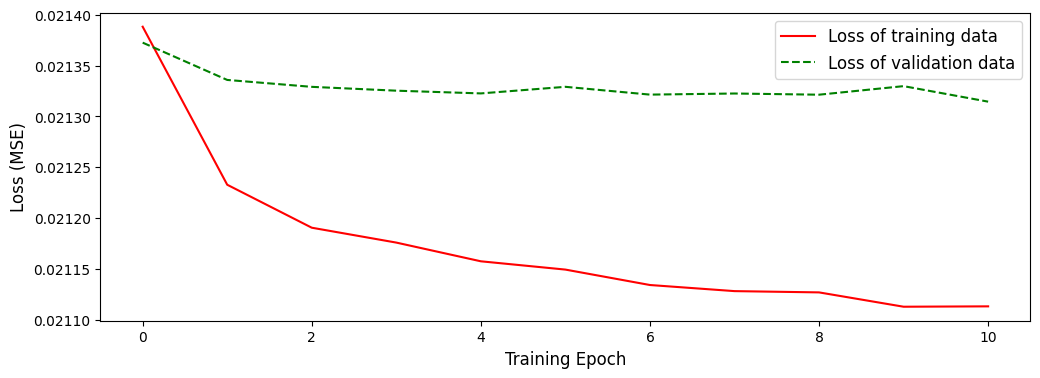

In [89]:
for i, history in enumerate(full_history):
    plt.figure(figsize=(12, 4))                                                     
    plt.plot(history.history['loss'], "r", label="Loss of training data", antialiased=True)
    plt.plot(history.history['val_loss'], "g--", label="Loss of validation data", antialiased=True)
    #plt.title('Model Loss: ' + reversed_list[i],fontsize=15)                                            
    plt.ylabel('Loss (MSE)', fontsize=12)                                                 
    plt.xlabel('Training Epoch', fontsize=12)                                                                                                                       
    plt.legend(fontsize=12)                                                                    
    plt.show()     

In [22]:
%who

Conv1D	 Conv1DTranspose	 Sequential	 adam_optimizer	 adc_groups	 adc_grp	 autoencoder	 batch_size_	 dataset	 
earlystop	 full_history	 full_x	 history	 i	 isfile	 join	 keras	 layer	 
listdir	 load_model	 mean	 np	 num_train_samples	 os	 plt	 reversed_list	 shuffle	 
std	 sys	 test_idx	 tf	 time_periods	 train_idx	 val_idx	 wireplane	 x_idx	 
x_train_scaled	 x_valid_scaled	 y_idx	 y_train_scaled	 y_valid_scaled	 


In [24]:
model_t = load_model('/home/vlian/Workspace/LArTPC-1DCNN-AutoEncoder/Neutrino-Trained-New-Dataset/AutoEncoder-Current/train_large_dataset/models/model_AE_12800_low_ADC_5_10Uplane_nu.h5')

In [91]:
adc = 5
x_test_scaled = (dataset[adc-5][test_idx][x_idx]-scalers[0])/scalers[1]
x_test = dataset[adc-5][test_idx][x_idx]
y_test = dataset[adc-5][test_idx][y_idx]
print('start inference...')
#pred = model_t.predict(x_test_scaled, batch_size=2048)
pred = autoencoder.predict(x_test_scaled, batch_size=2048)
pred = pred.reshape(pred.shape[0], pred.shape[1])
pred = pred*scalers[1] + scalers[0]

tp = [i for i, wave in enumerate(pred) if max(wave) >= 3 and max(y_test[i]) != 0]
bk_rej = [i for i, wave in enumerate(pred) if max(wave) >= 3 and max(y_test[i]) == 0]

print('TPr: ', len(tp)/y_test.shape[0]*100)
print('bk_rej: ', 100 -(len(bk_rej)/y_test.shape[0])*100)

start inference...
16/16 [==============================] - 0s 6ms/step
TPr:  4.7281249999999995
bk_rej:  99.33125


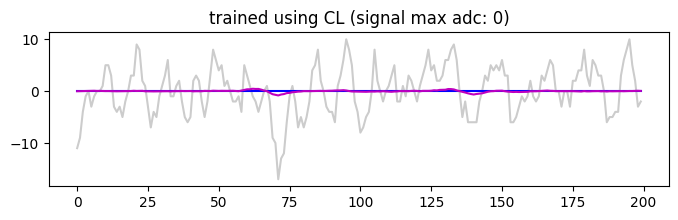

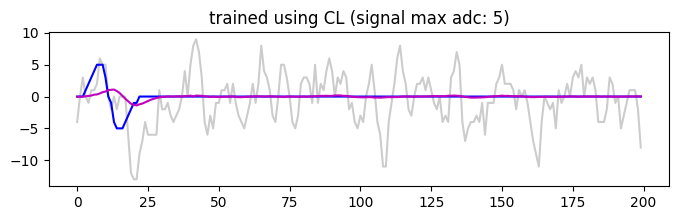

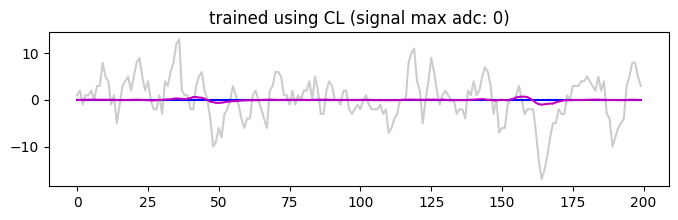

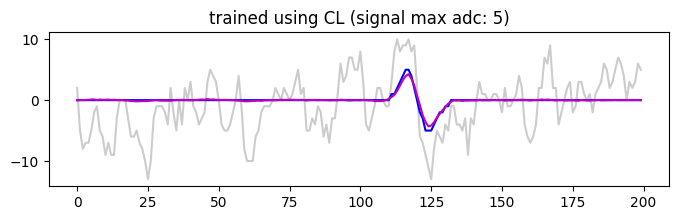

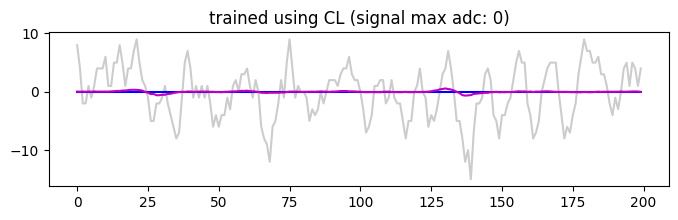

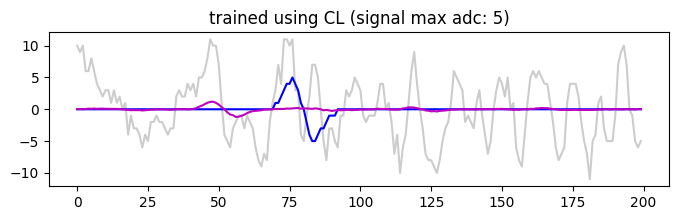

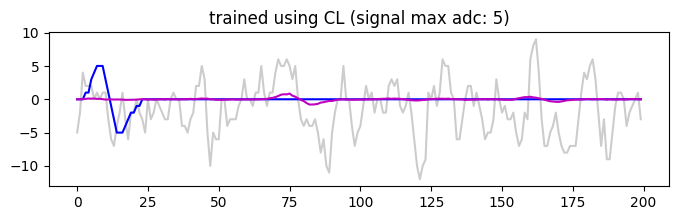

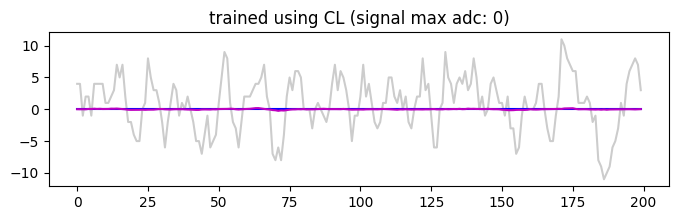

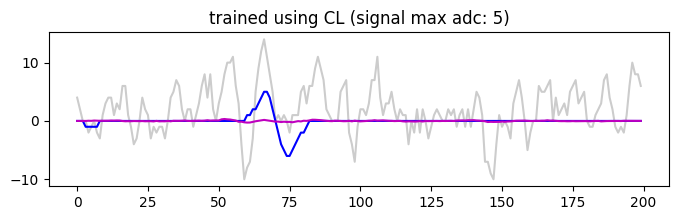

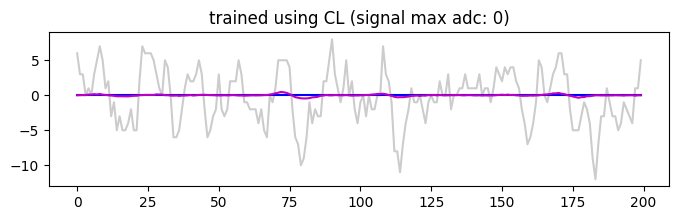

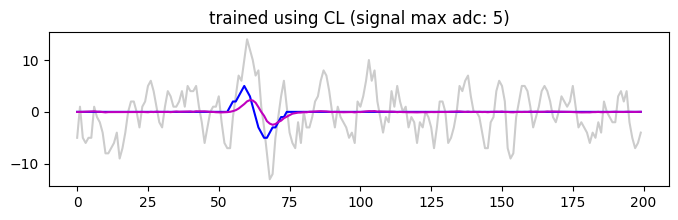

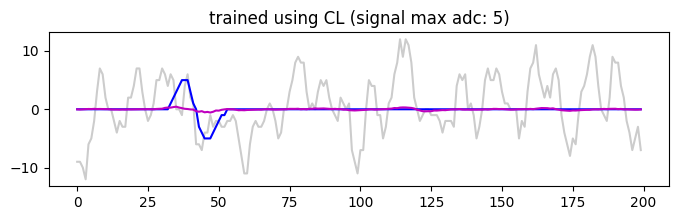

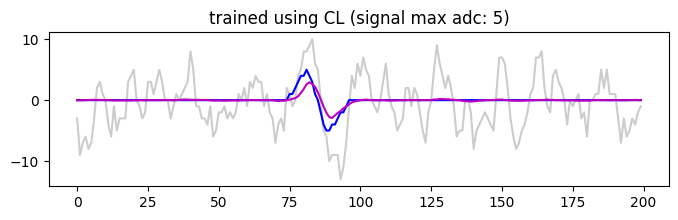

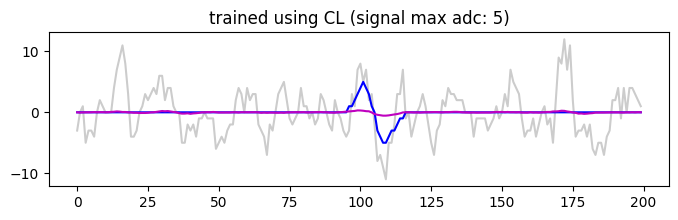

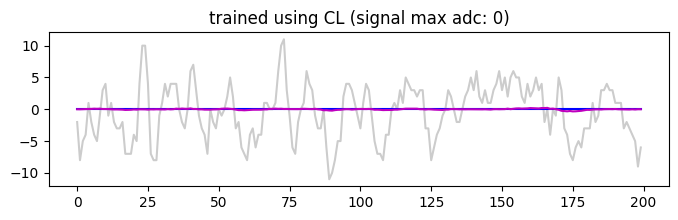

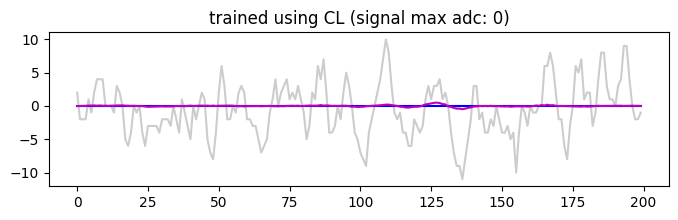

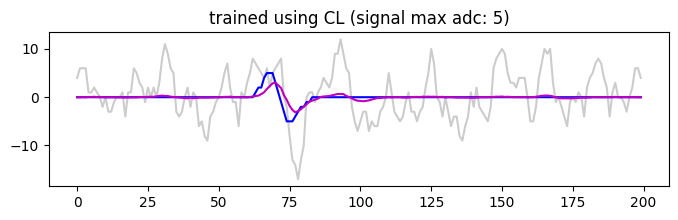

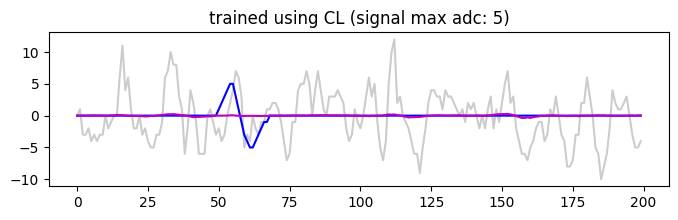

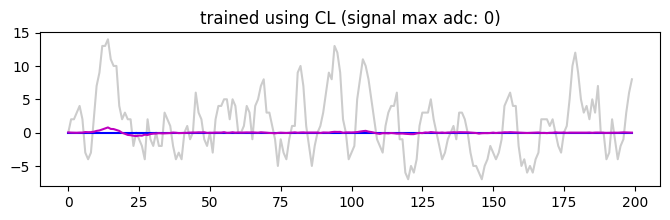

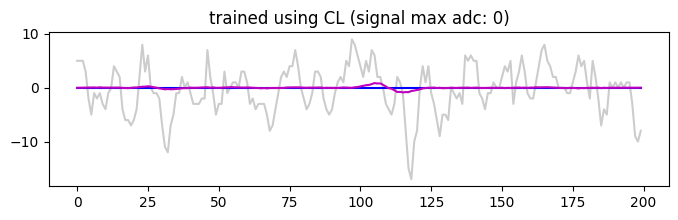

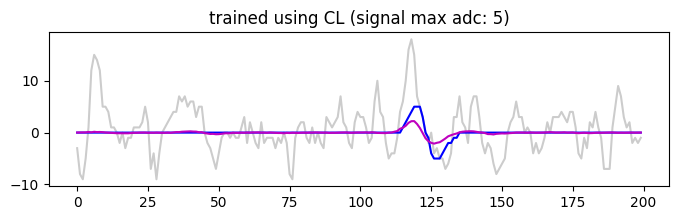

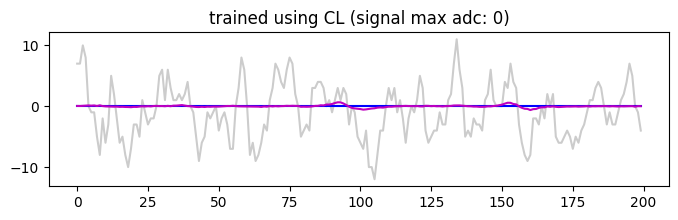

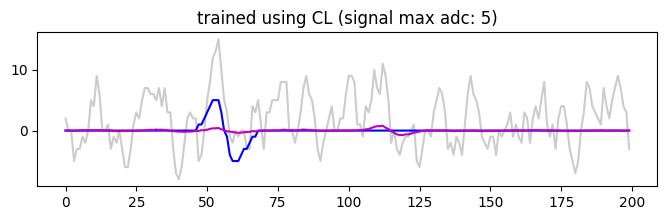

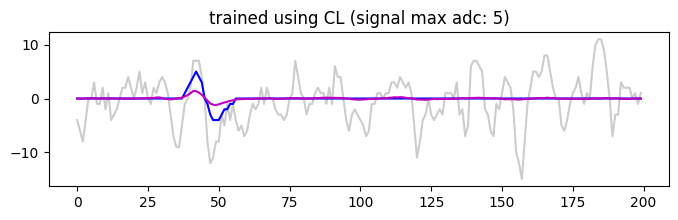

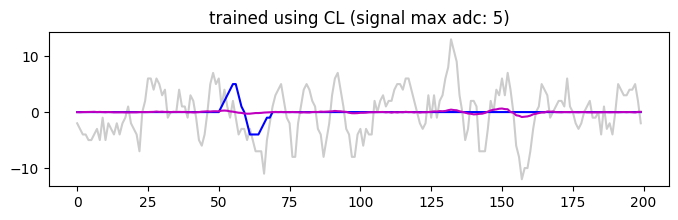

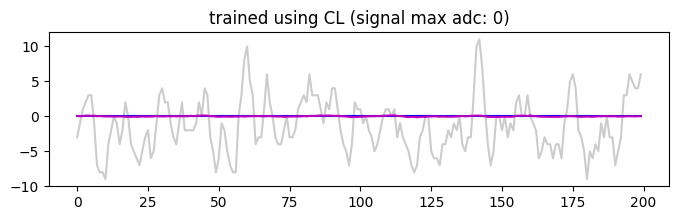

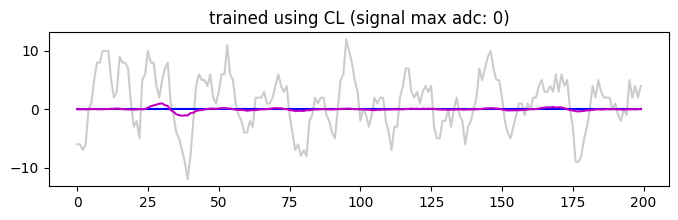

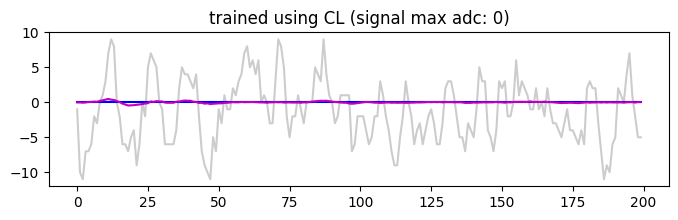

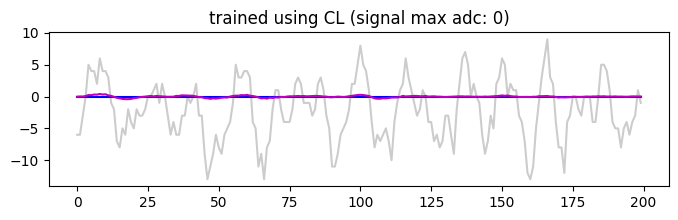

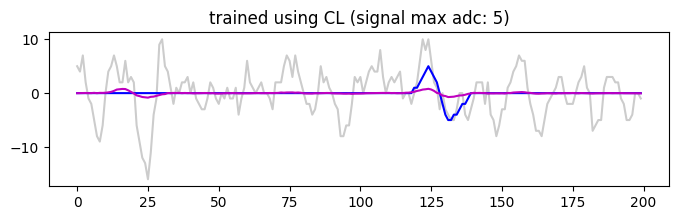

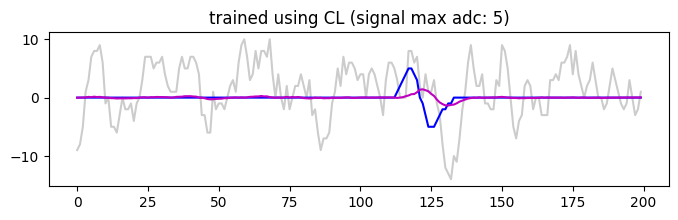

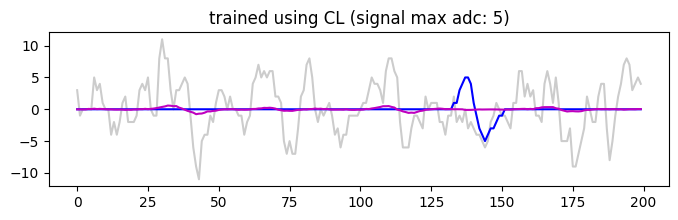

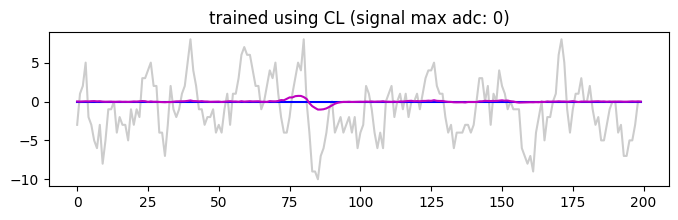

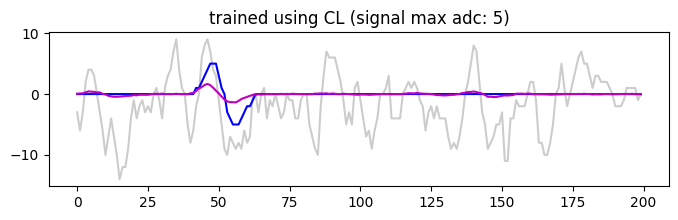

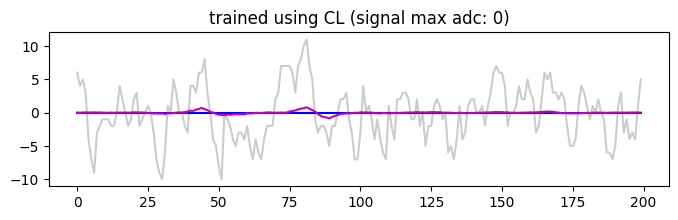

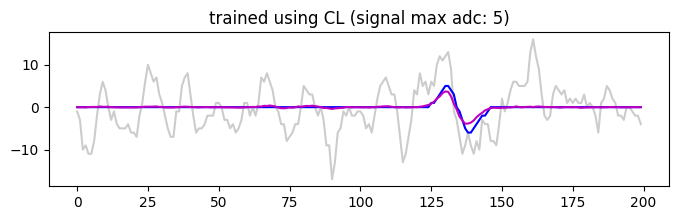

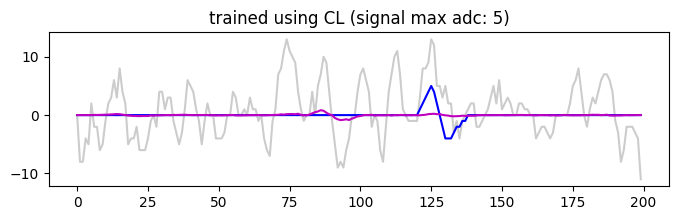

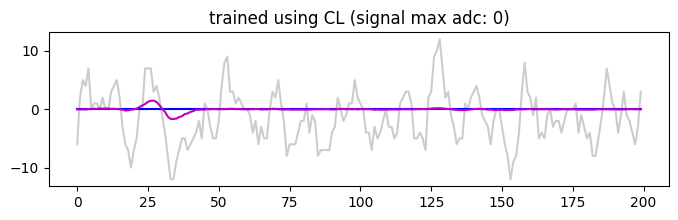

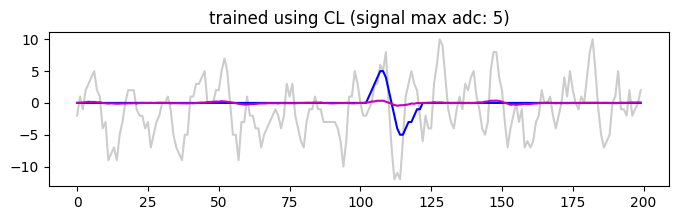

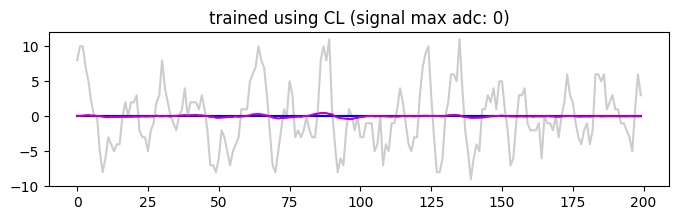

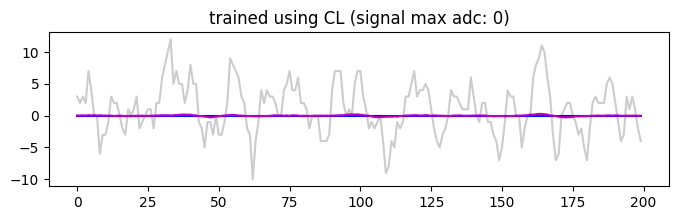

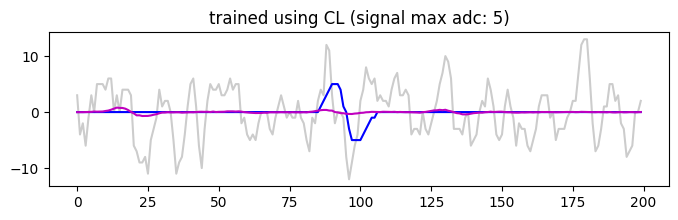

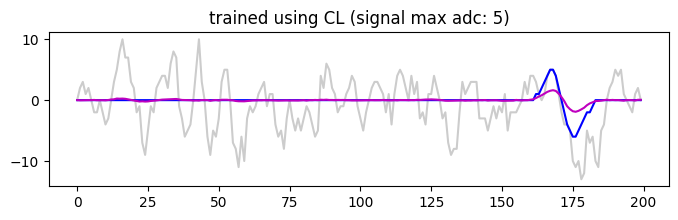

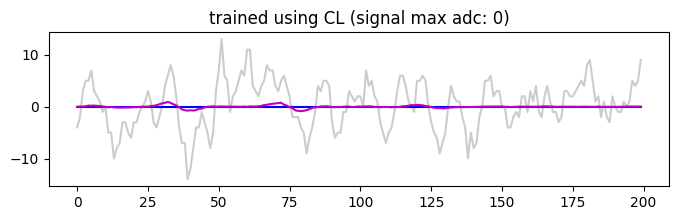

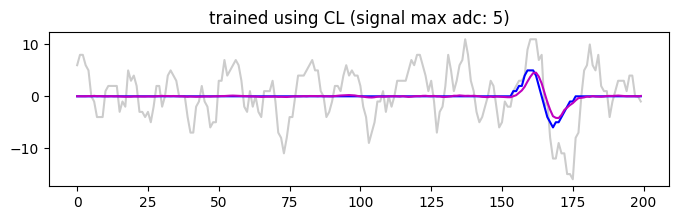

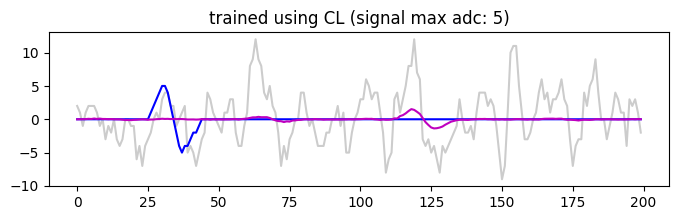

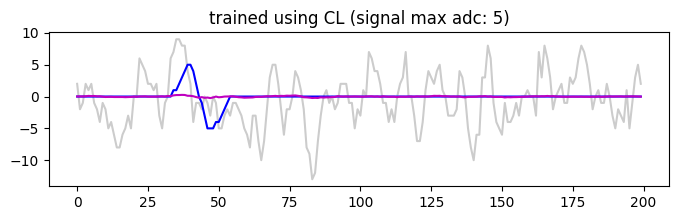

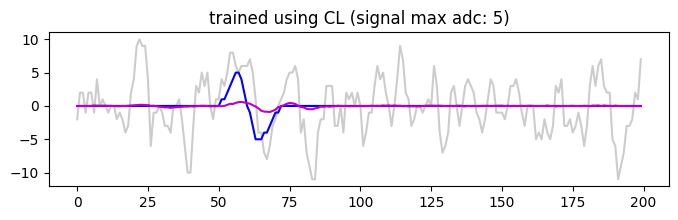

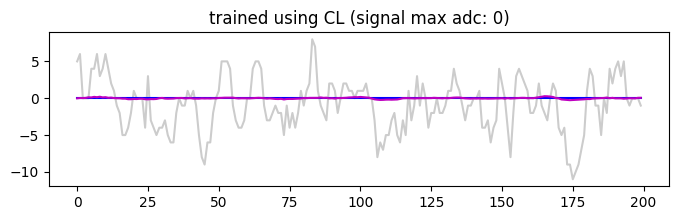

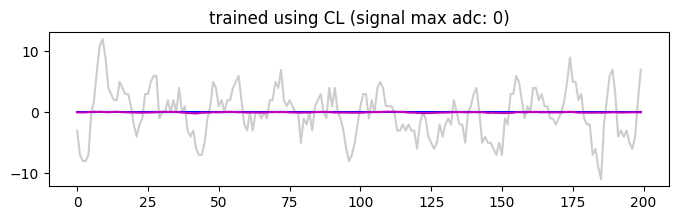

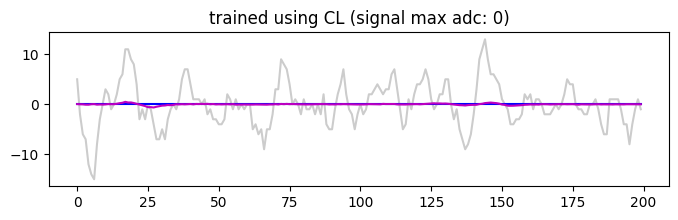

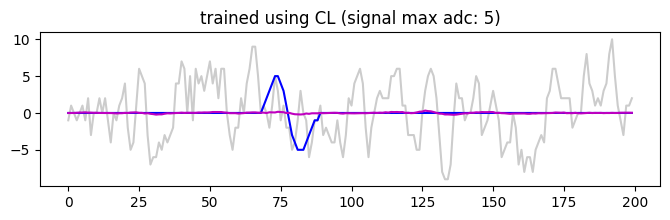

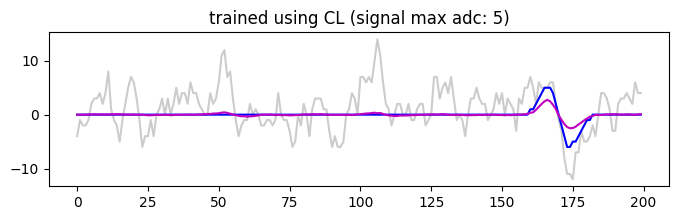

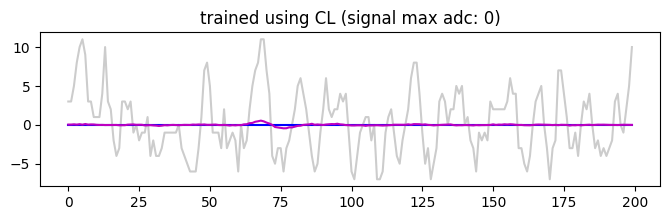

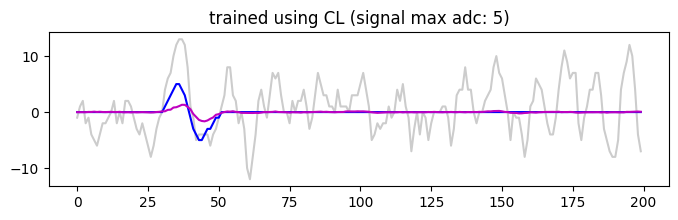

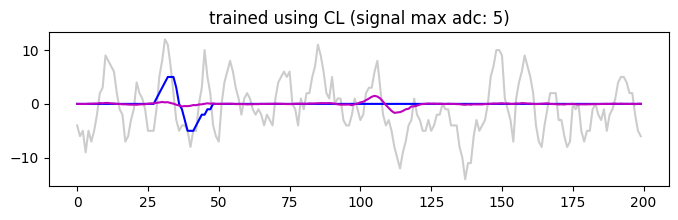

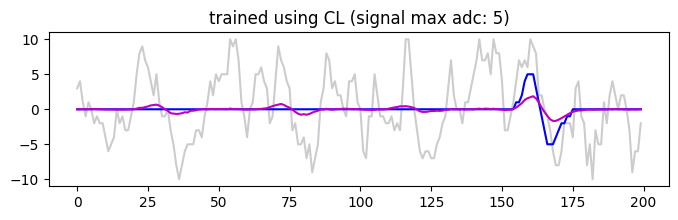

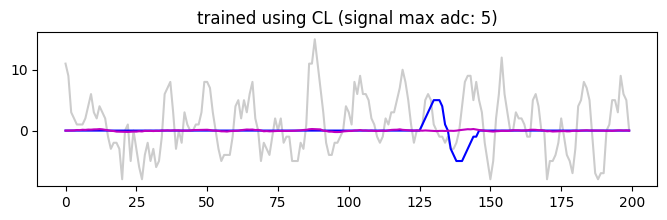

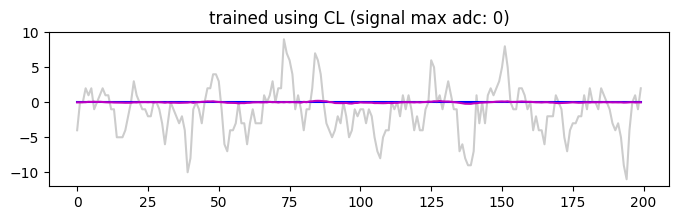

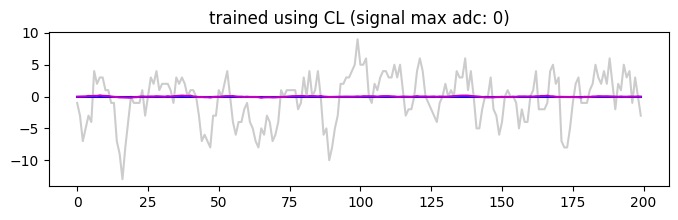

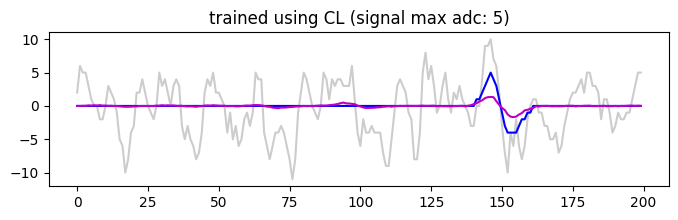

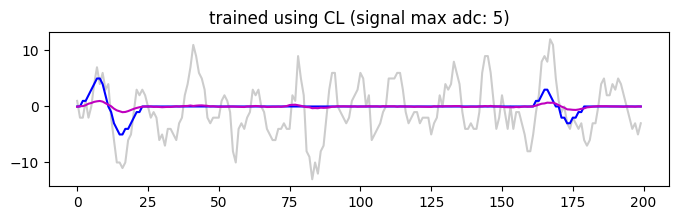

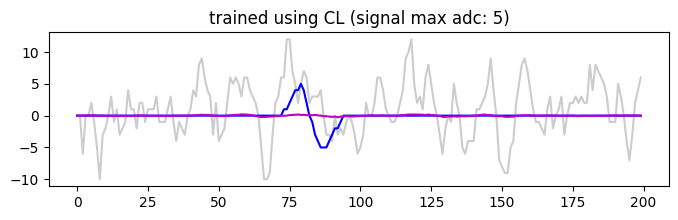

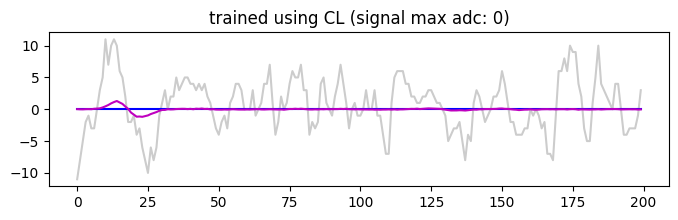

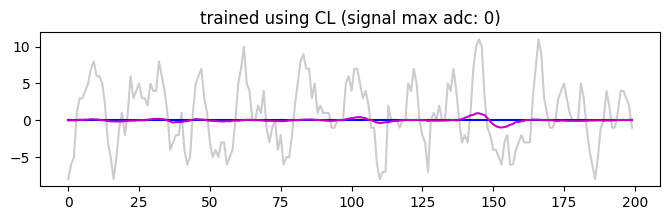

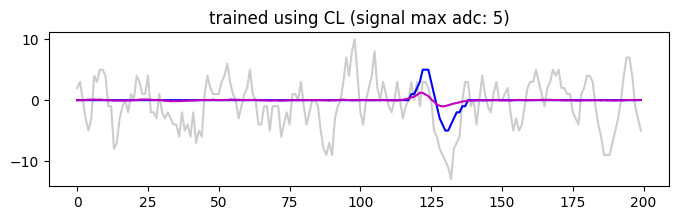

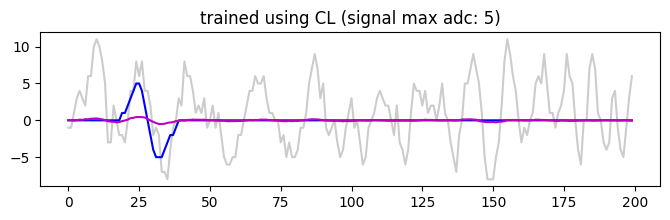

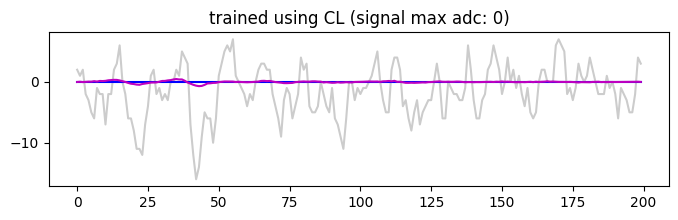

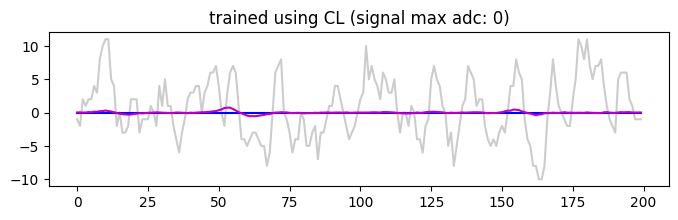

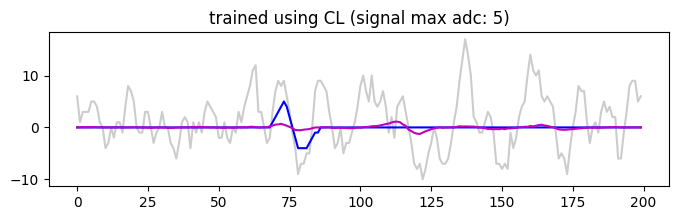

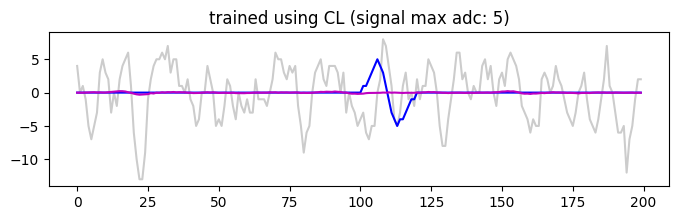

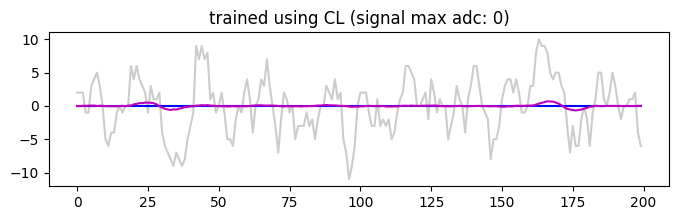

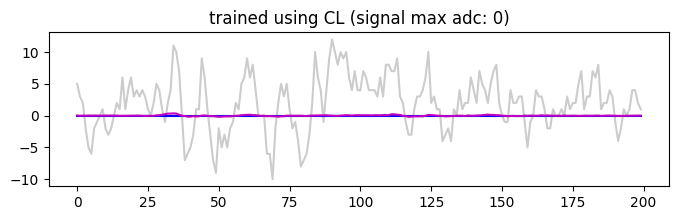

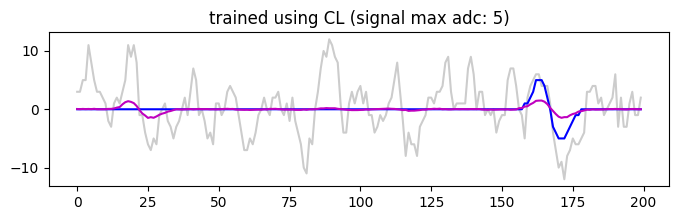

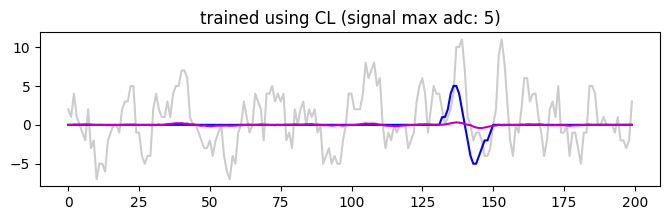

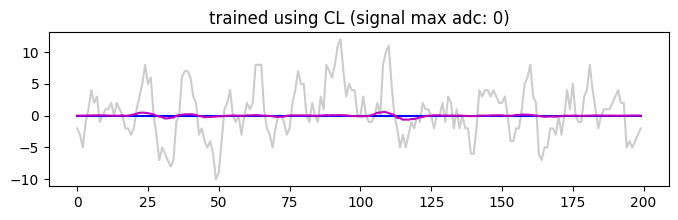

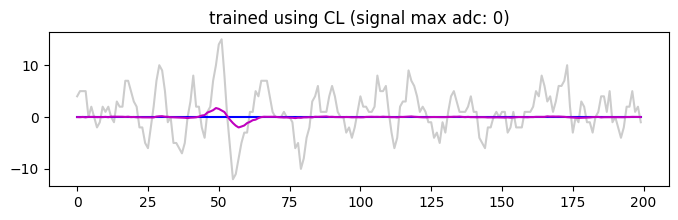

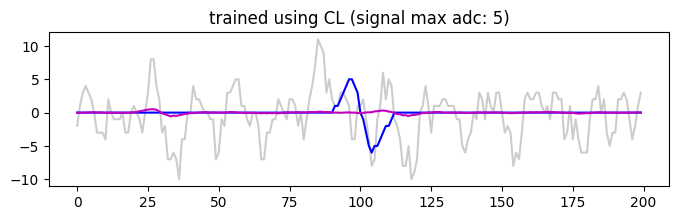

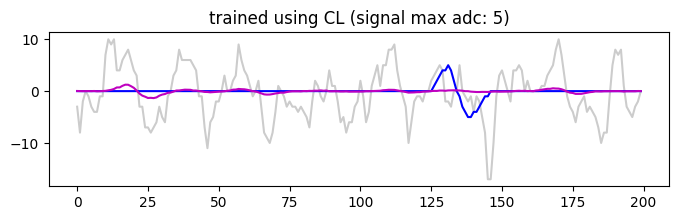

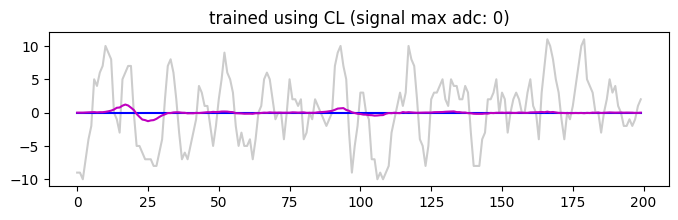

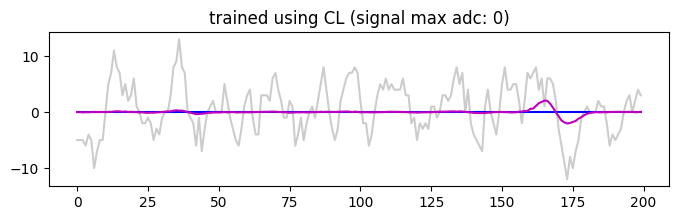

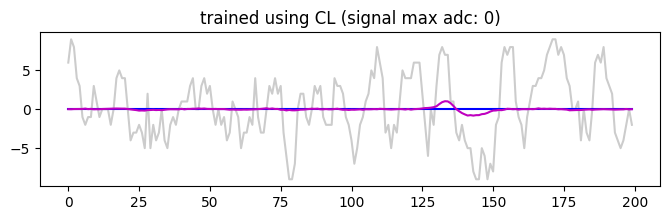

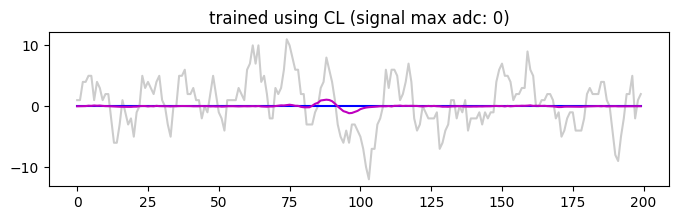

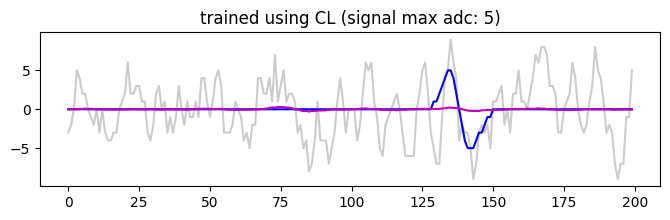

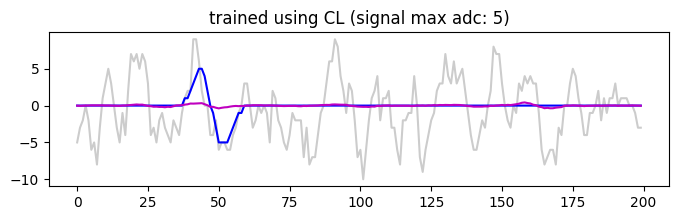

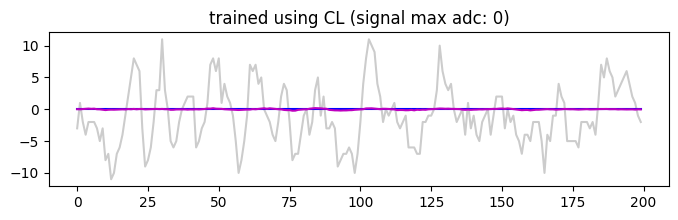

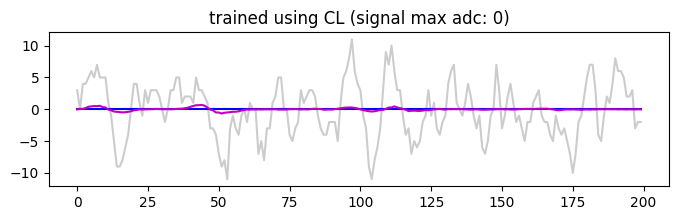

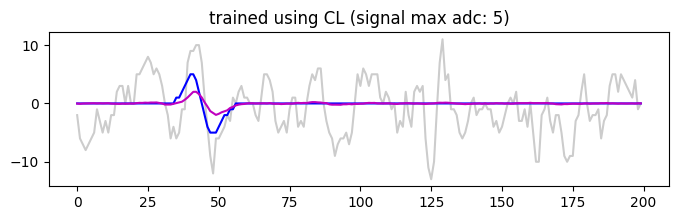

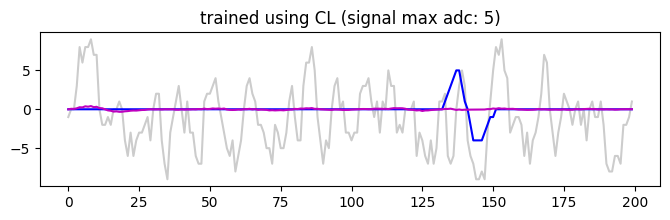

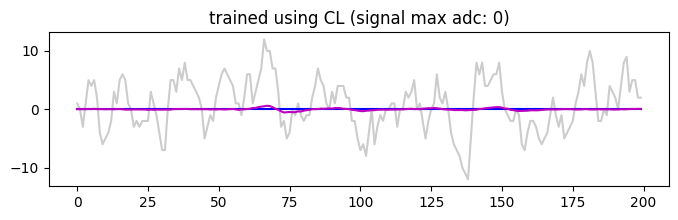

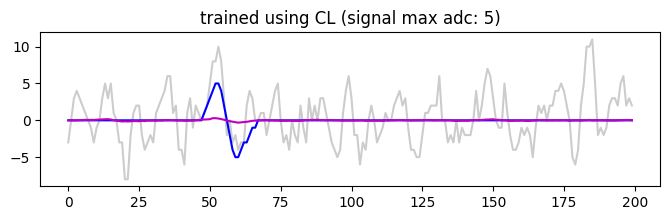

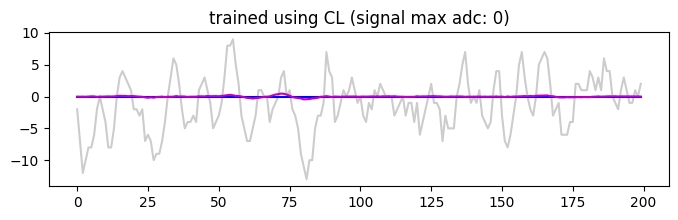

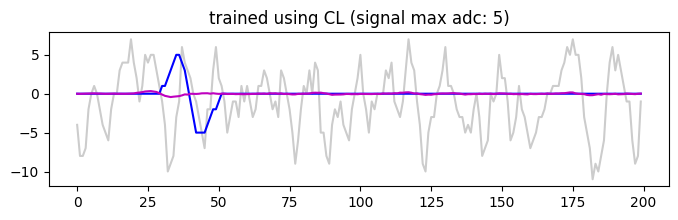

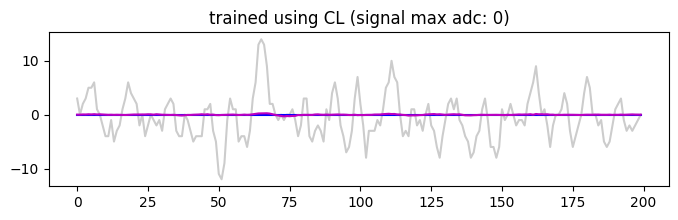

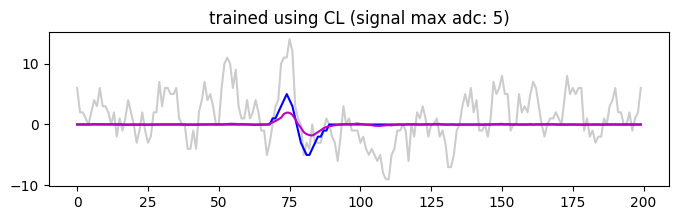

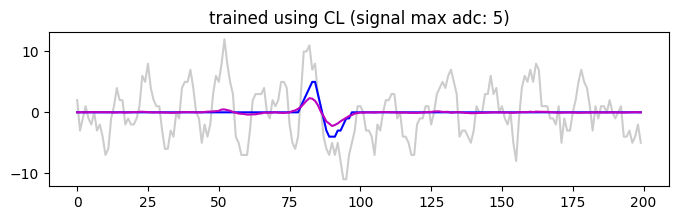

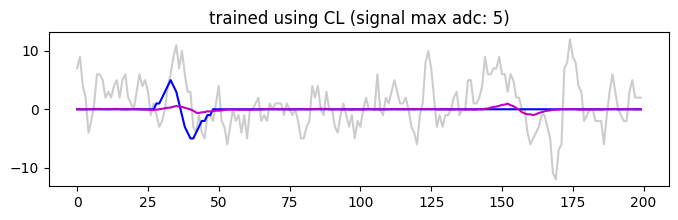

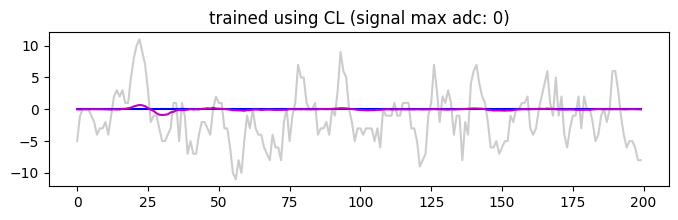

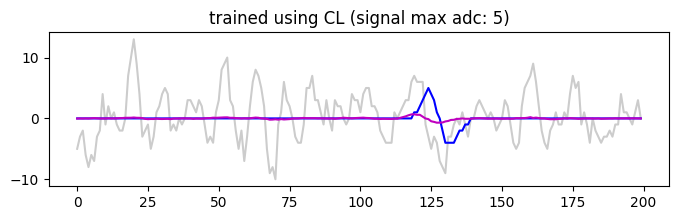

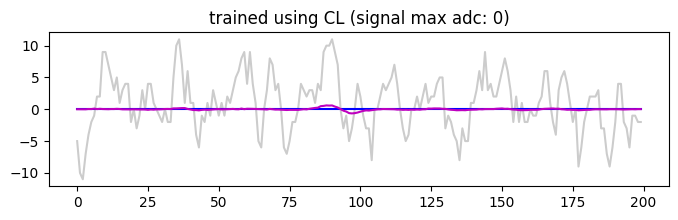

In [92]:
for i in range(100):
    fig = plt.figure(figsize=(8,2))
    plt.plot(x_test[i], color='black', alpha=0.2)
    plt.plot(y_test[i], color='blue')
    plt.plot(pred[i], color='m')
    plt.title('trained using CL (signal max adc: ' + str(int(max(y_test[i]))) + ')')
    plt.show()